In [1]:
# -*- coding: utf-8 -*-
"""CycleGAN.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1BuI-9P1-ku00Nc1tPbBhoeL006-3tNUS
"""

import torch
import torch.nn as nn

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae,mean_squared_error as mse
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as A
import random, torch, os, numpy as np
import torch.nn as nn
import copy
import torch.nn.functional as F


def asmape(y_true, y_pred, mask=None):
    if mask is not None:
         y_true, y_pred = y_true[mask==1], y_pred[mask==1]
    if type(y_true) is list or type(y_pred) is list:
         y_true, y_pred = np.array(y_true), np.array(y_pred)
    len_ = len(y_true)
    tmp = 100 * (np.nansum(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))/len_)

    return tmp
 


class LoaderDataset(Dataset):
    def __init__(self, root_zebra, root_horse, root_masks, chanels=3):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.root_index = root_masks
        
        self.zebra_images = sorted(os.listdir(root_zebra))
        self.horse_images = sorted(os.listdir(root_horse))
        self.index = sorted(os.listdir(root_masks))

        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)
        self.index_len = len(self.index)
        self.chanels = chanels

    def __len__(self):
        return self.length_dataset

    @staticmethod
    def custom_normalize(image):
        image = torch.tensor(image, dtype=torch.float32)
        min_val = torch.min(image)
        max_val = torch.max(image)
        scale = torch.clamp(max_val - min_val, min=1e-5)  # Evita divisão por zero
        image_normalized = 2 * (image - min_val) / scale - 1  # Escala para [-1, 1]
        return image_normalized, min_val, max_val

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]
        index_ids = self.index[index % self.index_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)
        index_path = os.path.join(self.root_index, index_ids)

        zebra_img = np.load(zebra_path)
        horse_img = np.load(horse_path)
        mask = np.load(index_path)

        if len(zebra_img.shape) > 3:
            zebra_img = zebra_img.reshape(32, 32, 3)
            horse_img = horse_img.reshape(32, 32, 3)

        zebra_img = np.transpose(zebra_img, (2, 0, 1))
        horse_img = np.transpose(horse_img, (2, 0, 1))

        if self.chanels == 2:
            zebra_img = zebra_img[:2, :, :]
            horse_img = horse_img[:2, :, :]
        elif self.chanels == 1:
            zebra_img = np.sum(zebra_img, axis=0, keepdims=True)
            horse_img = np.sum(horse_img, axis=0, keepdims=True)

        zebra_img, min_val_z, max_val_z = LoaderDataset.custom_normalize(zebra_img)
        horse_img, _, _ = LoaderDataset.custom_normalize(horse_img)

        mask = torch.tensor(mask, dtype=torch.float32)

        return zebra_img, horse_img, min_val_z, max_val_z, mask
		
# class ConvolutionalBlock(nn.Module):
#     def __init__(
#         self,
#         in_channels: int,
#         out_channels: int,
#         is_downsampling: bool = True,
#         add_activation: bool = True,
#         **kwargs
#     ):
#         super().__init__()
#         if is_downsampling:
#             self.conv = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
#                 nn.InstanceNorm2d(out_channels),
#                 nn.ReLU(inplace=True) if add_activation else nn.Identity(),
#             )
#         else:
#             self.conv = nn.Sequential(
#                 nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
#                 nn.InstanceNorm2d(out_channels),
#                 nn.ReLU(inplace=True) if add_activation else nn.Identity(),
#             )

#     def forward(self, x):
#         return self.conv(x)

# class ResidualBlock(nn.Module):
#     def __init__(self, channels: int):
#         """
#         In a residual block, the use of two ConvBlock instances with one having
#         an activation function and the other not is a design choice that promotes
#         the learning of residual information.

#         The purpose of a residual block is to learn the residual mapping between
#         the input and output of the block. The first ConvBlock in the sequence,
#         which includes an activation function, helps in capturing and extracting
#         important features from the input. The activation function introduces
#         non-linearity, allowing the network to model complex relationships
#         between the input and output.

#         The second ConvBlock does not include an activation function.
#         It mainly focuses on adjusting the dimensions (e.g., number of channels)
#         of the features extracted by the first ConvBlock. The absence of an
#         activation function in the second ConvBlock allows the block to learn
#         the residual information. By directly adding the output of the second
#         ConvBlock to the original input, the block learns to capture the
#         residual features or changes needed to reach the desired output.

#         (Information and explanation above generated by ChatGPT)
#         """
#         super().__init__()
#         self.block = nn.Sequential(
#             ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
#             ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
#         )

#     def forward(self, x):
#         """
#         This skip connection, achieved through the addition operation, helps
#         in propagating gradients during training and alleviates the vanishing
#         gradient problem. It also facilitates the flow of information from earlier
#         layers to later layers, allowing the network to learn more effectively.

#         (Information and explanation above generated by ChatGPT)
#         """
#         return x + self.block(x)

# class Generator(nn.Module):
#     def __init__(
#         self, img_channels: int, num_features: int = 64, num_residuals: int = 9
#     ):
#         """
#         Generator consists of 2 layers of downsampling/encoding layer,
#         followed by 9 residual blocks for 128 × 128 training images
#         and then 3 upsampling/decoding layer.

#         The network with 6 residual blocks can be written as:
#         c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.

#         The network with 9 residual blocks consists of:
#         c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
#         """
#         super().__init__()
#         self.initial_layer = nn.Sequential(
#             nn.Conv2d(
#                 img_channels,
#                 num_features,
#                 kernel_size=7,
#                 stride=1,
#                 padding=3,
#                 padding_mode="reflect",
#             ),
#             nn.ReLU(inplace=True),
#         )

#         self.downsampling_layers = nn.ModuleList(
#             [
#                 ConvolutionalBlock(
#                     num_features,
#                     num_features * 2,
#                     is_downsampling=True,
#                     kernel_size=3,
#                     stride=2,
#                     padding=1,
#                 ),
#                 ConvolutionalBlock(
#                     num_features * 2,
#                     num_features * 4,
#                     is_downsampling=True,
#                     kernel_size=3,
#                     stride=2,
#                     padding=1,
#                 ),
#             ]
#         )

#         self.residual_layers = nn.Sequential(
#             *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
#         )

#         self.upsampling_layers = nn.ModuleList(
#             [
#                 ConvolutionalBlock(
#                     num_features * 4,
#                     num_features * 2,
#                     is_downsampling=False,
#                     kernel_size=3,
#                     stride=2,
#                     padding=1,
#                     output_padding=1,
#                 ),
#                 ConvolutionalBlock(
#                     num_features * 2,
#                     num_features * 1,
#                     is_downsampling=False,
#                     kernel_size=3,
#                     stride=2,
#                     padding=1,
#                     output_padding=1,
#                 ),
#             ]
#         )

#         self.last_layer = nn.Conv2d(
#             num_features * 1,
#             img_channels,
#             kernel_size=7,
#             stride=1,
#             padding=3,
#             padding_mode="reflect",
#         )

#     def forward(self, x):
#         x = self.initial_layer(x)
#         for layer in self.downsampling_layers:
#             x = layer(x)
#         x = self.residual_layers(x)
#         for layer in self.upsampling_layers:
#             x = layer(x)
#         return torch.tanh(self.last_layer(x))




# === Instance Normalization Custom (como no TF) ===
class InstanceNormalization(nn.Module):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        # escala e offset serão inicializados no forward com parâmetros registrados

    def forward(self, x):
        # x shape: (N,C,H,W)
        mean = x.mean(dim=[2,3], keepdim=True)
        var = x.var(dim=[2,3], keepdim=True, unbiased=False)
        inv = 1.0 / torch.sqrt(var + self.epsilon)
        normalized = (x - mean) * inv

        # Criar escala e offset param se não existirem
        if not hasattr(self, 'scale'):
            self.scale = nn.Parameter(torch.ones(x.size(1), device=x.device))
            self.offset = nn.Parameter(torch.zeros(x.size(1), device=x.device))
        # reshape para broadcast
        scale = self.scale.view(1, -1, 1, 1)
        offset = self.offset.view(1, -1, 1, 1)
        return scale * normalized + offset

# === Downsample e Upsample ===
def downsample(in_ch, out_ch, norm_type='batchnorm', apply_norm=True):
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False)]
    if apply_norm:
        if norm_type == 'batchnorm':
            layers.append(nn.BatchNorm2d(out_ch))
        elif norm_type == 'instancenorm':
            layers.append(InstanceNormalization())
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def upsample(in_ch, out_ch, norm_type='batchnorm', apply_dropout=False):
    layers = [nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False)]
    if norm_type == 'batchnorm':
        layers.append(nn.BatchNorm2d(out_ch))
    elif norm_type == 'instancenorm':
        layers.append(InstanceNormalization())
    layers.append(nn.ReLU(inplace=True))
    if apply_dropout:
        layers.append(nn.Dropout(0.5))
    return nn.Sequential(*layers)


class UNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, norm_type='batchnorm', target_size=256):
        super().__init__()
        self.target_size = target_size
        self.down1 = downsample(input_channels, 64, norm_type, apply_norm=False)
        self.down2 = downsample(64, 128, norm_type)
        self.down3 = downsample(128, 256, norm_type)
        self.down4 = downsample(256, 512, norm_type)
        self.down5 = downsample(512, 512, norm_type)
        self.down6 = downsample(512, 512, norm_type)
        self.down7 = downsample(512, 512, norm_type)
        self.down8 = downsample(512, 512, norm_type)

        self.up1 = upsample(512, 512, norm_type, apply_dropout=True)
        self.up2 = upsample(1024, 512, norm_type, apply_dropout=True)
        self.up3 = upsample(1024, 512, norm_type, apply_dropout=True)
        self.up4 = upsample(1024, 512, norm_type)
        self.up5 = upsample(1024, 256, norm_type)
        self.up6 = upsample(512, 128, norm_type)
        self.up7 = upsample(256, 64, norm_type)

        self.final = nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        orig_size = x.shape[-2:]  # (H, W)

        # Upsample entrada para target_size x target_size
        x = F.interpolate(x, size=(self.target_size, self.target_size), mode='bilinear', align_corners=False)

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u1 = torch.cat([u1, d7], dim=1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d6], dim=1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d5], dim=1)

        u4 = self.up4(u3)
        u4 = torch.cat([u4, d4], dim=1)

        u5 = self.up5(u4)
        u5 = torch.cat([u5, d3], dim=1)

        u6 = self.up6(u5)
        u6 = torch.cat([u6, d2], dim=1)

        u7 = self.up7(u6)
        u7 = torch.cat([u7, d1], dim=1)

        output = self.final(u7)
        output = self.tanh(output)

        # Downsample a saída para o tamanho original da entrada
        output = F.interpolate(output, size=orig_size, mode='bilinear', align_corners=False)

        return output

/home/mauricio/.conda/envs/pyt_envmau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mauricio/.conda/envs/pyt_envmau/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def load_checkpoint(checkpoint_file, model, DEVICE):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file,weights_only=True, map_location=DEVICE)  # Carrega o estado salvo
    model.load_state_dict(checkpoint)  # Usa diretamente o dicionário de pesos
    return model

In [3]:

import pandas as pd

def test(gen_Z, test_loader, taxa, fold, chanells,DEVICE):
		ignore_index = ['MT_039_4.npy','MT_057_1.npy','MT_057_10.npy','MT_188_33.npy' ,'MT_194_19.npy','MT_227_27.npy ']

		gen_Z.eval()
		
		with torch.no_grad():
			# Criar o DataFrame com as colunas desejadas
			df = pd.DataFrame([], columns=['mae', 'asmape' ,'mape', 'rmse', 'scale'], index=test_loader.dataset.horse_images)

			for (zebra, horse, min_val, max_val, mask), name in zip(test_loader, test_loader.dataset.horse_images):
				# Verificar as dimensões das entradas
				if name in ignore_index:
					print(f'Ignorando {name}')
					continue
				# Mover dados para o dispositivo
				zebra = zebra.to(DEVICE)
				horse = horse.to(DEVICE)

				# Converter std_val e mean_val para tensores e movê-los para o dispositivo
				# std_val = torch.tensor(std_val, device=DEVICE) if not isinstance(std_val, torch.Tensor) else std_val.to(DEVICE)
				# mean_val = torch.tensor(mean_val, device=DEVICE) if not isinstance(mean_val, torch.Tensor) else mean_val.to(DEVICE)

				# Gerar fake_zebra usando o gerador
				fake_zebra = gen_Z(horse)

				# Mover apenas as imagens para a CPU antes de operações subsequentes
				zebra = zebra.cpu()
				fake_zebra = fake_zebra.cpu()

				# Voltar para escala original 
				zebra = ((zebra+1)/2)* (max_val.cpu()-min_val.cpu()) + min_val.cpu()
				fake_zebra = (fake_zebra +1)/2 * (max_val.cpu()-min_val.cpu()) + min_val.cpu()
				# Somar sobre o canal e achatar as imagens
				zebra = torch.sum(zebra, dim=1).flatten()
				fake_zebra = torch.sum(fake_zebra, dim=1).flatten()

				# Calcular as métricas
				zebra_np = zebra*mask
				fake_zebra_np = fake_zebra*mask

				# Calcular as métricas corretamente
				mae_value = round(mae(zebra_np, fake_zebra_np), 3)
				mape_value = round(mape(zebra_np, fake_zebra_np) * 100, 3)
				rmse_value = round(np.sqrt(mse(zebra_np, fake_zebra_np)), 3)
				smape_value = round(asmape(zebra_np, fake_zebra_np, mask), 3)
				df.loc[name] = [mae_value, smape_value, mape_value, rmse_value, np.max(zebra.numpy()) - np.min(zebra.numpy())]

			# Salvar o DataFrame em um arquivo CSV
			directory =  "./resultados/resultados_ciclegan"
			if not os.path.exists(directory):
					os.makedirs(directory)

			df.to_csv(os.path.join(directory, f'result_{str(chanells)}c_{taxa}_{fold}.csv'))    

In [4]:
import time
import os
# import torch.multiprocessing as mp
TRAIN_DIR = os.path.abspath("../dataset_final")  
VAL_DIR = os.path.abspath("../dataset_final")  
INDEX_TRAIN = os.path.abspath("../dataset_final")  
INDEX_VAL = os.path.abspath("../dataset_final")  
INDEX_TEST = os.path.abspath("../dataset_final")  

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")



# 3) Agora carregue o checkpoint normalmente


def main(in_channels):
    
    gen_Z = UNetGenerator(input_channels=in_channels, output_channels=in_channels, norm_type='instancenorm').to(DEVICE)

    # 2) Faça um forward “dummy” para que todas as suas InstanceNormalization criem
    #    e registrem scale/offset corretamente no state_dict do modelo
    dummy_in = torch.zeros(1, in_channels, gen_Z.target_size, gen_Z.target_size, device=DEVICE)
    _ = gen_Z(dummy_in)

    		
    for taxa in ['10','20','30','40']:
        for fold in ['1','2','3','4','5']:  
        
            test_dataset = LoaderDataset(
                  root_zebra=os.path.join( VAL_DIR, "label", str(taxa), "folds", f"fold{fold}", "test"),
									root_horse=os.path.join( VAL_DIR, "input", str(taxa), "folds", f"fold{fold}", "test"),
									root_masks=os.path.join(INDEX_TEST, "input", str(taxa), "folds", f"fold{fold}", "index"),
									chanels=in_channels
						)
            
            test_loader = DataLoader(
                    test_dataset,
                    batch_size=1,
                    shuffle=False,
                    pin_memory=False )
            
            #Treino        
           
        
            save_dir = f"./models_saved/cyclegan/{in_channels}/{taxa}/fold{fold}"
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
                
            # Salvar modelo
            model_path = os.path.join(save_dir, "generator.pth")
            load_checkpoint(model_path, gen_Z, DEVICE)
            gen_Z.eval()

            # Teste
            
            test(gen_Z,test_loader=test_loader,taxa=taxa,fold=fold,chanells=in_channels,DEVICE=DEVICE)

if __name__ == '__main__':
    start_time = time.time()
  # Necessário no Windows para compatibilidade
    for i in [1,2,3]:
        print(f'{i} channels: Iniciando o teste ....')
        main(i)
    total_time = time.time() - start_time
    print(f'{total_time/3600} horas')

1 channels: Iniciando o teste ....
=> Loading checkpoint
Ignorando MT_039_4.npy
Ignorando MT_057_1.npy
Ignorando MT_057_10.npy
Ignorando MT_188_33.npy
Ignorando MT_194_19.npy
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
Ignorando MT_039_4.npy
Ignorando MT_057_1.npy
Ignorando MT_057_10.npy
Ignorando MT_188_33.npy
Ignorando MT_194_19.npy
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
Ignorando MT_039_4.npy
Ignorando MT_057_1.npy
Ignorando MT_057_10.npy
Ignorando MT_188_33.npy
Ignorando MT_194_19.npy
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
Ignorando MT_039_4.npy
Ignorando MT_057_1.npy
Ignorando MT_057_10.npy
Ignorando MT_188_33.npy
Ignorando MT_194_19.npy
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
2 channels: Iniciando o teste ....
=> Loading checkpo

In [5]:
import pandas as pd
import os
directory =  "./resultados/resultados_ciclegan"

# Caminho do arquivo CSV
for taxa in ['10','20','30','40']:
		for fold in ['1','2','3','4','5']:
				for chanells in [1,2,3]:
					file_path = os.path.join(directory, f'result_{str(chanells)}c_{taxa}_{fold}.csv')

					# Carrega o DataFrame
					df = pd.read_csv(file_path, index_col=0)

					# Filtra os índices com MAPE > 100
					filt = df['mape'] > 100

					# Mostra quantos índices satisfazem a condição
					num_acima_100 = filt.sum()

					# Exibe os índices e valores correspondentes (opcional)
					acima_100 = df[filt]

					print(f"{num_acima_100} de {df.shape[0]} índices com MAPE > 100")
					print(acima_100)


1 de 372 índices com MAPE > 100
                mae  asmape          mape    rmse     scale
MT_227_27.npy  3.35  10.596  1.050409e+16  12.215  382.5486
0 de 372 índices com MAPE > 100
Empty DataFrame
Columns: [mae, asmape, mape, rmse, scale]
Index: []
2 de 372 índices com MAPE > 100
                 mae  asmape          mape    rmse      scale
MT_093_1.npy   3.430  74.953  1.115140e+02  12.777  225.50763
MT_227_27.npy  1.936   5.292  3.634303e+16   7.370  382.54858
5 de 371 índices com MAPE > 100
                          mae  asmape          mape   rmse       scale
MT_015_1.npy            0.740  64.726  2.810653e+17  2.890   67.019630
MT_174_33.npy           0.966   8.363  3.151677e+16  3.907  211.382490
MT_181_6.npy            0.869   5.967  2.234657e+16  3.619  174.319140
distillate-flow_33.npy  0.776  56.642  1.349731e+17  2.874   37.445133
distillate-flow_37.npy  0.937  75.723  3.635425e+17  3.965   51.548000
6 de 371 índices com MAPE > 100
                           mae  asmape  

In [6]:
import pandas as pd
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
taxa = 10
fold=1
in_channels =1
 
VAL_DIR = os.path.abspath("../dataset_final")   
INDEX_TEST = os.path.abspath("../dataset_final")  

test_dataset = LoaderDataset(
                  root_zebra=os.path.join( VAL_DIR, "label", str(taxa), "folds", f"fold{fold}", "test"),
									root_horse=os.path.join( VAL_DIR, "input", str(taxa), "folds", f"fold{fold}", "test"),
									root_masks=os.path.join(INDEX_TEST, "input", str(taxa), "folds", f"fold{fold}", "index"),
									chanels=in_channels
						)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

save_dir = f"./models_saved/cyclegan/{in_channels}/{taxa}/fold{fold}"
model_path = os.path.join(save_dir, "generator.pth")

gen_Z = UNetGenerator(input_channels=1, output_channels=1, norm_type='instancenorm').to(DEVICE)


# 2) Faça um forward “dummy” para que todas as suas InstanceNormalization criem
#    e registrem scale/offset corretamente no state_dict do modelo
dummy_in = torch.zeros(1, 1, gen_Z.target_size, gen_Z.target_size, device=DEVICE)
_ = gen_Z(dummy_in)

# 3) Agora carregue o checkpoint normalmente
load_checkpoint(model_path, gen_Z, DEVICE)
gen_Z.eval()
previsoes = {}
reais={}
ignore_index = ['MT_039_4.npy','MT_057_1.npy','MT_057_10.npy','MT_188_33.npy' ,'MT_194_19.npy','MT_227_27.npy ']
with torch.no_grad():
	# Criar o DataFrame com as colunas desejadas
	df = pd.DataFrame([], columns=['mae', 'asmape' ,'mape', 'rmse', 'scale'], index= [i[:6] for i in test_loader.dataset.horse_images])

	for (zebra, horse, min_val, max_val, mask), name in zip(test_loader, test_loader.dataset.horse_images):
		# Verificar as dimensões das entradas

		# Mover dados para o dispositivo
		zebra = zebra.to(DEVICE)
		horse = horse.to(DEVICE)
		if name in ignore_index:
			print(f'Ignorando {name}')
			continue

		# Converter std_val e mean_val para tensores e movê-los para o dispositivo
		# std_val = torch.tensor(std_val, device=DEVICE) if not isinstance(std_val, torch.Tensor) else std_val.to(DEVICE)
		# mean_val = torch.tensor(mean_val, device=DEVICE) if not isinstance(mean_val, torch.Tensor) else mean_val.to(DEVICE)

		# Gerar fake_zebra usando o gerador
		fake_zebra = gen_Z(horse)

		# Mover apenas as imagens para a CPU antes de operações subsequentes
		zebra = zebra.cpu()
		fake_zebra = fake_zebra.cpu()

		# Voltar para escala original 
		zebra = ((zebra+1)/2)* (max_val.cpu()-min_val.cpu()) + min_val.cpu()
		fake_zebra = (fake_zebra +1)/2 * (max_val.cpu()-min_val.cpu()) + min_val.cpu()
		# Somar sobre o canal e achatar as imagens
		zebra = torch.sum(zebra, dim=1).flatten()
		fake_zebra = torch.sum(fake_zebra, dim=1).flatten()


		# Calcular as métricas
		zebra_np = zebra*mask
		fake_zebra_np = fake_zebra*mask

		previsoes[name] = fake_zebra_np.numpy()[fake_zebra_np.numpy() != 0]
		reais[name] = zebra_np.numpy()[zebra_np.numpy() != 0]

		# Calcular as métricas corretamente
		mae_value = round(mae(zebra_np, fake_zebra_np), 3)
		mape_value = round(mape(zebra_np, fake_zebra_np) * 100, 3)
		rmse_value = round(np.sqrt(mse(zebra_np, fake_zebra_np)), 3)
		smape_value = round(asmape(zebra_np, fake_zebra_np, mask), 3)
		# Adicionar os resultados ao DataFram
		df.loc[name[:6]] = [mae_value, smape_value, mape_value, rmse_value, np.max(zebra.numpy()) - np.min(zebra.numpy())]
	

=> Loading checkpoint
Ignorando MT_039_4.npy
Ignorando MT_057_1.npy
Ignorando MT_057_10.npy
Ignorando MT_188_33.npy
Ignorando MT_194_19.npy


In [7]:
df_grouped = df.groupby(df.index).mean()

In [8]:
df_grouped.T.describe()

,Bike S,MT_003,MT_005,MT_010,MT_013,MT_015,MT_020,MT_033,MT_036,MT_039,...,MT_236,MT_237,MT_240,MT_243,MT_247,Sunspo,ammoni,daily-,distil,electr
count,5.000,5.000,5.000,5.00,5.000,5.000,5.000,5.000,5.000,5.000,...,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.00,5.000
unique,5.000,5.000,5.000,5.00,5.000,5.000,5.000,5.000,5.000,5.000,...,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.00,5.000
top,3.495,0.021,0.357,0.56,0.677,0.224,0.362,0.303,0.496,0.327,...,0.716,0.313,2.161,1.046,2.092,0.815,0.365,0.155,3.05,0.003
freq,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.00,1.000


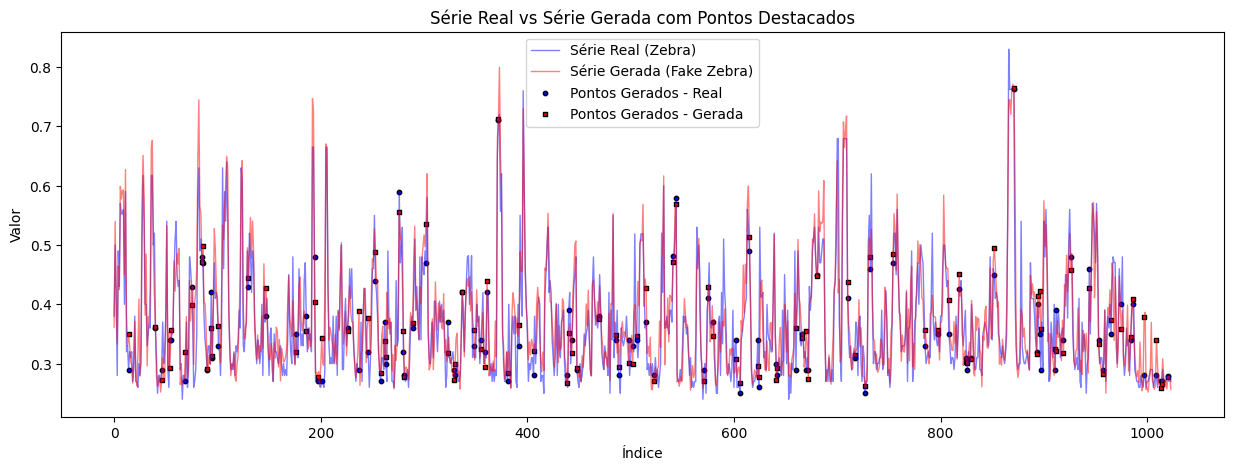

In [9]:
import numpy as np
import matplotlib.pyplot as plt



# Aplicando a máscara para destacar os pontos gerados
zebra_np = zebra*mask
fake_zebra_np = fake_zebra*mask

# Índices dos pontos gerados (onde mask == 1)
generated_indices = np.argwhere(mask == 1)[1]

# Plotando as séries
plt.figure(figsize=(15, 5))
plt.plot(zebra, label="Série Real (Zebra)", color="blue", alpha=0.5,linewidth=1)
plt.plot(fake_zebra, label="Série Gerada (Fake Zebra)", color="red", alpha=0.5,linewidth=1)

# Destacando os pontos gerados
plt.scatter(generated_indices ,zebra[generated_indices], color="blue", marker="o", label="Pontos Gerados - Real", edgecolors="black",s=10)
plt.scatter(generated_indices, fake_zebra[generated_indices], color="red", marker="s", label="Pontos Gerados - Gerada", edgecolors="black",s=5)
 

plt.legend()
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.title("Série Real vs Série Gerada com Pontos Destacados")
plt.show()

In [10]:
# Agrupa os valores de reais por prefixo
new_dict_reais = {}
prefixos = set(i[:6] for i in reais.keys())

for prefixo in prefixos:
    temp = []
    for k in reais.keys():
        if k.startswith(prefixo):
            temp.append(reais[k])
    new_dict_reais[prefixo] = np.concatenate(temp)

# Agrupa os valores de previsoes por prefixo
new_dict_previsoes = {}

for prefixo in prefixos:
    temp = []
    for k in previsoes.keys():
        if k.startswith(prefixo):
            temp.append(previsoes[k])
    new_dict_previsoes[prefixo] = np.concatenate(temp)


In [11]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Número de prefixos
# n = len(prefixos)
# ncols = 3  # ajuste conforme necessário
# nrows = int(np.ceil(n / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharex=False)
# axes = axes.flatten()  # Garante acesso linear, mesmo em 2D

# for i, name in enumerate(sorted(prefixos)):
#     ax = axes[i]
#     real = new_dict_reais[name]
#     fake = new_dict_previsoes[name]
    
#     ax.plot(real, label='Real', alpha=0.6)
#     ax.plot(fake, label='Previsão', alpha=0.6)
#     ax.set_title(name)
#     ax.legend()
#     ax.grid(True)

# # Remove subplots vazios se houver
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# fig.suptitle('Comparação entre Séries Reais e Previsões', fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()


In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# prefixos = list(new_dict_reais.keys())  # ou a lista que você tem

# n = len(prefixos)
# fig, axs = plt.subplots(n, 1, figsize=(15, 4 * n))

# if n == 1:
#     axs = [axs]

# for i, name in enumerate(prefixos):
#     real = new_dict_reais[name]
#     fake = new_dict_previsoes[name]

#     axs[i].plot(np.arange(len(real)), real, label=f'Real - {name}', alpha=0.6)
#     axs[i].plot(np.arange(len(fake)), fake, label=f'Fake - {name}', alpha=0.6)

#     axs[i].set_xlim(0, max(len(real), len(fake)))
#     axs[i].set_ylabel('Valor')
#     axs[i].set_title(f'Série: {name}')
#     axs[i].legend()

# axs[-1].set_xlabel('Índice')

# plt.tight_layout()
# plt.show()
